In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
diff_df = {"subject": [], "comparison": [], "models": [], "∆ R2": []}

for sub in ["sub-01", "sub-02", "sub-03", "sub-05", "sub-06"]:
    path_ram_test = sorted(glob.glob(f"../outputdata/models/RAM_ridge/{sub}_*/RAM_test_r2.npy"))[-1]
    r2_ram_test = np.load(path_ram_test)
    path_ram_ood = sorted(glob.glob(f"../outputdata/models/RAM_ridge/{sub}_*/RAM_ood_r2.npy"))[-1]
    r2_ram_ood = np.load(path_ram_ood)
    path_ppo_test = glob.glob(f"../outputdata/models/PPO_ridge/{sub}_ep-7800_*/base.conv3_test_r2.npy")[-1]
    r2_ppo_test = np.load(path_ppo_test)
    path_ppo_ood = glob.glob(f"../outputdata/models/PPO_ridge/{sub}_ep-7800_*/base.conv3_ood_r2.npy")[-1]
    r2_ppo_ood = np.load(path_ppo_ood)
    path_untrained_test = glob.glob(f"../outputdata/models/Random_ridge/{sub}_random_*/base.conv3_test_r2.npy")[-1]
    r2_untrained_test = np.load(path_untrained_test)
    path_untrained_ood = glob.glob(f"../outputdata/models/Random_ridge/{sub}_random_*/base.conv3_ood_r2.npy")[-1]
    r2_untrained_ood = np.load(path_untrained_ood)
    
    delta_ram_wd_ood = np.abs(r2_ram_test - r2_ram_ood).mean()
    delta_ppo_wd_ood = np.abs(r2_ppo_test - r2_ppo_ood).mean()
    delta_unt_wd_ood = np.abs(r2_untrained_test - r2_untrained_ood).mean()
    delta_ram_ppo_wd = np.abs(r2_ram_test - r2_ppo_test).mean()
    delta_ram_unt_wd = np.abs(r2_ram_test - r2_untrained_test).mean()
    delta_ppo_unt_wd = np.abs(r2_ppo_test - r2_untrained_test).mean()
    delta_ram_ppo_ood = np.abs(r2_ram_ood - r2_ppo_ood).mean()
    delta_ram_unt_ood = np.abs(r2_ram_ood - r2_untrained_ood).mean()
    delta_ppo_unt_ood = np.abs(r2_ppo_ood - r2_untrained_ood).mean()
    
    diff_df["subject"] += [sub] * 9
    diff_df["comparison"] += ["WD - OOD"] * 3 + ["WD model"] * 3 + ["OOD model"] * 3
    diff_df["models"] += ["PPO", "Unt.", "RAM"] + ["PPO-Unt.", "PPO-RAM", "RAM-Unt."] * 2
    diff_df["∆ R2"] += [delta_ppo_wd_ood, delta_unt_wd_ood, delta_ram_wd_ood,
                        delta_ppo_unt_wd, delta_ram_ppo_wd, delta_ram_unt_wd,
                        delta_ppo_unt_ood, delta_ram_ppo_ood, delta_ram_unt_ood]
   
diff_df = pd.DataFrame.from_dict(diff_df)

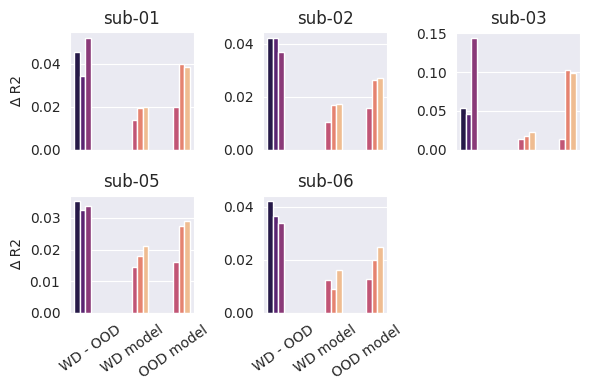

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

sns.set_style("darkgrid")
fig, axs = plt.subplots(2, 3, figsize=(6, 4))

for i, sub in enumerate(diff_df["subject"].unique()):
    row = i // 3
    col = i % 3
    
    sns.barplot(data=diff_df.query(f"subject=='{sub}'"), x="comparison", y="∆ R2", hue="models",
                palette="magma", dodge=True,
                #hue_order=["PPO", "Untrained", "RAM"], 
                legend=False,#sub == "sub-01", 
                ax=axs[row, col])
    #if sub == "sub-01":
    #    sns.move_legend(axs[row, col], "upper left", bbox_to_anchor=(2.5, -0.5))
    
    axs[row, col].set_title(sub)
    if row < 1:
        axs[row, col].tick_params(axis='x', labelbottom=False)
    else:
        axs[row, col].tick_params(axis='x', labelrotation=35)
    if col > 0:
        axs[row, col].set_ylabel('')
    axs[row, col].set_xlabel('')


axs[1, 2].axis('off')  # Turn off axis for the empty subplot

plt.tight_layout()
plt.show()

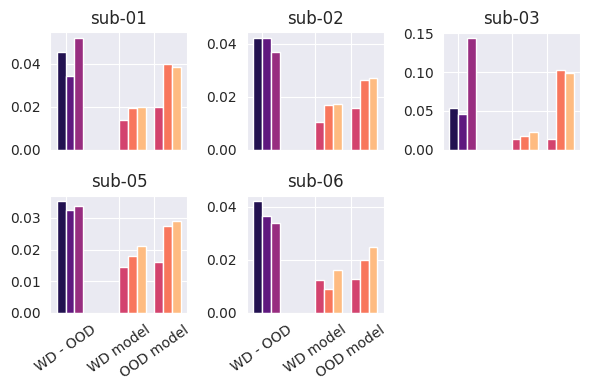

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Plot style
sns.set_style("darkgrid")
BAR_WIDTH = 0.25
fig, axs = plt.subplots(2, 3, figsize=(6, 4))

subjects = sorted(diff_df["subject"].unique())
model_order = ["PPO", "Unt.", "RAM", "PPO-Unt.", "PPO-RAM", "RAM-Unt."]
palette = dict(zip(model_order, sns.color_palette("magma", len(model_order))))

# Manual label offsets (in x-axis units)
group_label_offsets = {
    "WD - OOD": -0.5,
    "WD model": 0.0,
    "OOD model": 0.0
}

for i, sub in enumerate(subjects):
    row, col = divmod(i, 3)
    ax = axs[row, col]

    sub_df = diff_df[diff_df["subject"] == sub]
    comparisons = sub_df["comparison"].unique()

    group_centers = np.arange(len(comparisons))

    for j, model in enumerate(model_order):
        model_df = sub_df[sub_df["models"] == model]
        if model_df.empty:
            continue
        model_vals = model_df.set_index("comparison").reindex(comparisons)["∆ R2"].values
        offsets = group_centers + (j - len(model_order) / 2) * BAR_WIDTH + BAR_WIDTH / 2
        ax.bar(offsets, model_vals, width=BAR_WIDTH, label=model, color=palette[model])

    # Set adjusted xticks per comparison group
    xticks = [group_centers[k] + group_label_offsets.get(comp, 0.0)
              for k, comp in enumerate(comparisons)]

    ax.set_title(sub)
    ax.set_xticks(xticks)
    if row == 1:
        ax.set_xticklabels(comparisons, rotation=35)
    else:
        ax.set_xticklabels([])

    if col > 0:
        ax.set_ylabel('')
    ax.set_xlabel('')

axs[1, 2].axis('off')
plt.tight_layout()
plt.show()


In [6]:
diff_df

,subject,comparison,models,∆ R2
0,sub-01,WD - OOD,PPO,0.045356
1,sub-01,WD - OOD,Unt.,0.034461
2,sub-01,WD - OOD,RAM,0.051973
3,sub-01,WD model,PPO-Unt.,0.013712
4,sub-01,WD model,PPO-RAM,0.019331
5,sub-01,WD model,RAM-Unt.,0.019909
6,sub-01,OOD model,PPO-Unt.,0.019814
7,sub-01,OOD model,PPO-RAM,0.039836
8,sub-01,OOD model,RAM-Unt.,0.038557
9,sub-02,WD - OOD,PPO,0.042172
